Chargement du dataset ML final (836k lignes)...
Dataset chargé. Shape: (836126, 29)
Définition des features pour le Modèle C (Démo + Finance)...
Features (X) sélectionnées: 22 au total
Target (y) sélectionnée: is_failed_in_3y
Ratio de déséquilibre (sur 836k lignes): 69.54
Création du Preprocessor 'Monstre' (OHE + RobustScaler)...
Création de la pipeline (Preprocessor + XGBoost)...
Entraînement du Modèle C (Monstre)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle C...
---
--- RÉSULTATS DU MODÈLE C (MODÈLE 'MONSTRE') ---
Score ROC-AUC (Final): 0.7627
---
Rapport de Classification (Final):
               precision    recall  f1-score   support

Survivant (0)       1.00      0.59      0.74    164855
 Faillite (1)       0.03      0.83      0.05      2371

     accuracy                           0.59    167226
    macro avg       0.51      0.71      0.40    167226
 weighted avg       0.98      0.59      0.73    167226

---
Matrice de Confusion (Final):


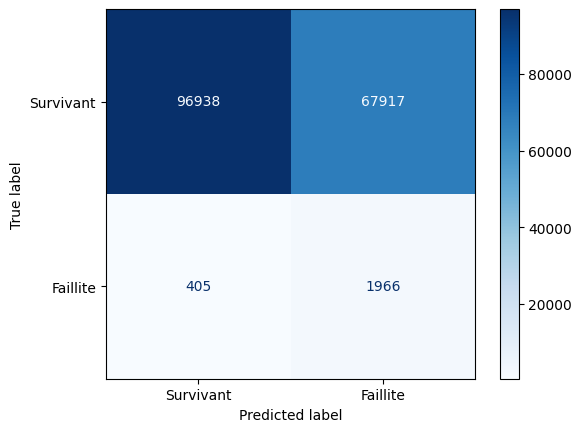

Extraction des Feature Importances...
TOP 20 des features les plus importantes :
                                  feature  importance
694  activitePrincipaleUniteLegale_68.20A    0.045141
0      categorieJuridiqueUniteLegale_1000    0.039576
599  activitePrincipaleUniteLegale_47.99A    0.020688
604  activitePrincipaleUniteLegale_49.32Z    0.014564
630  activitePrincipaleUniteLegale_53.20Z    0.012219
786  activitePrincipaleUniteLegale_86.90E    0.012055
3      categorieJuridiqueUniteLegale_2210    0.009529
79     categorieJuridiqueUniteLegale_6598    0.009482
785  activitePrincipaleUniteLegale_86.90D    0.008511
222  activitePrincipaleUniteLegale_10.71D    0.007269
62     categorieJuridiqueUniteLegale_6540    0.006766
813  activitePrincipaleUniteLegale_93.11Z    0.006617
597  activitePrincipaleUniteLegale_47.91A    0.006614
128    categorieJuridiqueUniteLegale_9220    0.006162
695  activitePrincipaleUniteLegale_68.20B    0.006158
814  activitePrincipaleUniteLegale_93.12Z    0.005743
1

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

In [3]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON IMPORTE LES DEUX PREPROCESSORS ▼▼▼
from sklearn.preprocessing import OneHotEncoder, RobustScaler
# ▲▲▲ ON IMPORTE LES DEUX PREPROCESSORS ▲▲▲
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL (LE COMPLET) ---
print("Chargement du dataset ML final (836k lignes)...")
try:
    df_final_ml = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset chargé. Shape: {df_final_ml.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 3 : LE "MONSTRE") ---
print("Définition des features pour le Modèle C (Démo + Finance)...")

# ▼▼▼ ON PREND LES DEUX GROUPES DE FEATURES ▼▼▼
DEMO_FEATURES = [
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "departement"
]

FINANCIAL_FEATURES = [
    'HN_RésultatNet',
    'FA_ChiffreAffairesVentes',
    'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut',
    'DL_DettesCourtTerme',
    'DM_DettesLongTerme',
    'DA_TresorerieActive',
    'FJ_ResultatFinancier',
    'FR_ResultatExceptionnel',
    'DF_CapitauxPropres',
    'EG_ImpotsTaxes',
    # Et aussi les 7 ratios experts !
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
]

ALL_FEATURES = DEMO_FEATURES + FINANCIAL_FEATURES
TARGET = "is_failed_in_3y"
# ▲▲▲ ON PREND LES DEUX GROUPES DE FEATURES ▲▲▲

# On convertit en Pandas pour Scikit-Learn
X = df_final_ml.select(ALL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {len(ALL_FEATURES)} au total")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE (sur 836k lignes) ---
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Ratio de déséquilibre (sur 836k lignes): {scale_pos_weight:.2f}")

# --- 4. PRÉPARATION (Le Preprocessor "Monstre") ---
# ▼▼▼ LE NOUVEAU PREPROCESSOR (LE CŒUR) ▼▼▼
print("Création du Preprocessor 'Monstre' (OHE + RobustScaler)...")

# Un transformer pour les 4 features catégorielles
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Un transformer pour les 18 features numériques (11 brutes + 7 ratios)
numerical_transformer = RobustScaler()

# On combine les deux avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, DEMO_FEATURES), # Applique OHE aux démo
        ("num", numerical_transformer, FINANCIAL_FEATURES) # Applique RobustScaler aux finance
    ],
    remainder="passthrough"
)
# ▲▲▲ LE NOUVEAU PREPROCESSOR (LE CŒUR) ▲▲▲

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
print("Création de la pipeline (Preprocessor + XGBoost)...")

model_C = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42,
        enable_categorical=False 
    ))
])

# --- 7. ENTRAÎNEMENT (Le "Monstre") ---
print("Entraînement du Modèle C (Monstre)...")
model_C.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score Final) ---
print("Évaluation du Modèle C...")
y_pred = model_C.predict(X_test)
y_pred_proba = model_C.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE C (MODÈLE 'MONSTRE') ---")
print(f"Score ROC-AUC (Final): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Final):")
print(report)
print("---")

# Plot Matrice de Confusion
print("Matrice de Confusion (Final):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 9. FEATURE IMPORTANCE (La Conclusion) ---
print("Extraction des Feature Importances...")

# On récupère le 'classifier' de la pipeline
classifier = model_C.named_steps['classifier']
# On récupère le 'preprocessor'
preprocessor_fitted = model_C.named_steps['preprocessor']

# On récupère les noms des features après le OHE
ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(DEMO_FEATURES)
# On combine les noms OHE + les noms financiers
all_feature_names = np.concatenate([ohe_feature_names, FINANCIAL_FEATURES])

# On crée un DataFrame d'importance
df_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': classifier.feature_importances_
}).sort_values(by='importance', ascending=False)

# On affiche le TOP 20
print("TOP 20 des features les plus importantes :")
print(df_importance.head(20))

# Plot du TOP 20
plt.figure(figsize=(10, 8))
sns.barplot(data=df_importance.head(20), x='importance', y='feature')
plt.title("TOP 20 Feature Importances (Modèle Monstre)")
plt.show()

Chargement du dataset ML final (836k lignes)...
Dataset chargé. Shape: (836126, 29)
Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...
Dataset 'Golden' filtré. Nouvelle Shape: (20817, 29)
Définition des features pour le Modèle C (Démo + Finance)...
Features (X) sélectionnées: 22 au total
Target (y) sélectionnée: is_failed_in_3y
Value Counts de la Target (sur 26k lignes):
is_failed_in_3y
0    20776
1       41
Name: count, dtype: int64
Création du Preprocessor 'Monstre' (OHE + RobustScaler)...
Taille du Test set: 4164. Nb Faillites dans le Test set: 8
Création de la pipeline (Preprocessor + SMOTE + XGBoost)...
Entraînement du Modèle C (Monstre 'Golden')...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle C...
---
--- RÉSULTATS DU MODÈLE C (MODÈLE 'MONSTRE') ---
Score ROC-AUC (Final): 0.5435
---
Rapport de Classification (Final):
               precision    recall  f1-score   support

Survivant (0)       1.00      1.00      1.00      4156
 Faillite (1)       0.00      0.00      0.00         8

     accuracy                           1.00      4164
    macro avg       0.50      0.50      0.50      4164
 weighted avg       1.00      1.00      1.00      4164

---
Matrice de Confusion (Final):


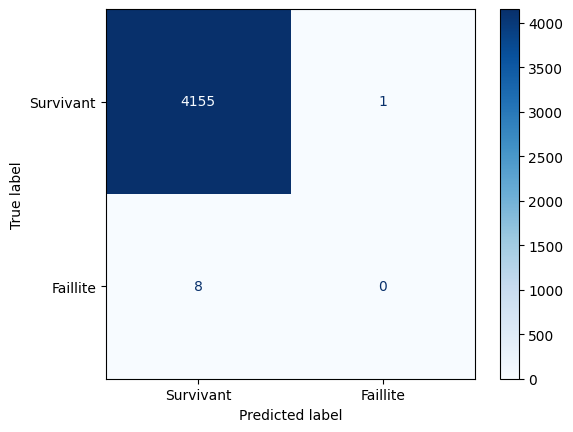

In [2]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON IMPORTE TOUS LES PREPROCESSORS ▼▼▼
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 
# ▲▲▲ ON IMPORTE TOUS LES PREPROCESSORS ▲▲▲
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL (LE COMPLET) ---
print("Chargement du dataset ML final (836k lignes)...")
try:
    df_full = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset chargé. Shape: {df_full.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

# --- 2. LE FILTRE "GOLDEN DATASET" ---
print("Filtrage: On ne garde que les entreprises avec bilan (les ~26k 'golden')...")
df_final_ml = df_full.filter(
    pl.col("ratio_rentabilite_nette") != 0 
)
print(f"Dataset 'Golden' filtré. Nouvelle Shape: {df_final_ml.shape}")

# --- 3. DÉFINITION DES FEATURES (LE "MONSTRE") ---
print("Définition des features pour le Modèle C (Démo + Finance)...")

DEMO_FEATURES = [
    "categorieJuridiqueUniteLegale",
    "trancheEffectifsUniteLegale",
    "activitePrincipaleUniteLegale",
    "departement"
]

FINANCIAL_FEATURES = [
    'HN_RésultatNet', 'FA_ChiffreAffairesVentes', 'FB_AchatsMarchandises',
    'CJCK_TotalActifBrut', 'DL_DettesCourtTerme', 'DM_DettesLongTerme',
    'DA_TresorerieActive', 'FJ_ResultatFinancier', 'FR_ResultatExceptionnel',
    'DF_CapitauxPropres', 'EG_ImpotsTaxes',
    "ratio_rentabilite_nette", "ratio_endettement", "ratio_marge_brute", 
    "ratio_capitaux_propres", "ratio_tresorerie",
    "ratio_resultat_financier", "ratio_resultat_exceptionnel"
]

ALL_FEATURES = DEMO_FEATURES + FINANCIAL_FEATURES
TARGET = "is_failed_in_3y"

X = df_final_ml.select(ALL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {len(ALL_FEATURES)} au total")
print(f"Target (y) sélectionnée: {y.name}")
print(f"Value Counts de la Target (sur 26k lignes):\n{y.value_counts()}")


# --- 4. PRÉPARATION (Le Preprocessor "Monstre") ---
print("Création du Preprocessor 'Monstre' (OHE + RobustScaler)...")

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numerical_transformer = RobustScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, DEMO_FEATURES), 
        ("num", numerical_transformer, FINANCIAL_FEATURES)
    ],
    remainder="passthrough"
)

# --- 5. SPLIT (Train / Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Taille du Test set: {X_test.shape[0]}. Nb Faillites dans le Test set: {y_test.sum()}")


# --- 6. CRÉATION DE LA PIPELINE "FINALE" (AVEC SMOTE) ---
print("Création de la pipeline (Preprocessor + SMOTE + XGBoost)...")
model_C = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), 
    ('classifier', XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# --- 7. ENTRAÎNEMENT (Le "Monstre") ---
print("Entraînement du Modèle C (Monstre 'Golden')...")
model_C.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score Final) ---
print("Évaluation du Modèle C...")
y_pred = model_C.predict(X_test)
y_pred_proba = model_C.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

print("---")
print("--- RÉSULTATS DU MODÈLE C (MODÈLE 'MONSTRE') ---")
print(f"Score ROC-AUC (Final): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Final):")
print(report)
print("---")

# Plot Matrice de Confusion
print("Matrice de Confusion (Final):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 9. FEATURE IMPORTANCE (La Conclusion) ---
# (Attention: complexe à extraire à cause de SMOTE et OHE)
# On va se concentrer sur le SCORE pour l'instant.